# IGF signaling pathway simulations

In [1]:
# Load packages
from MScausality.SCM_numpyro import SCM

import pandas as pd
import numpy as np

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pyro
import torch

import pickle 
import matplotlib.pyplot as plt
%matplotlib inline

## Build network

In [2]:
graph = nx.DiGraph()
graph.add_edge("EGF", "SOS")
graph.add_edge("EGF", "PI3K")
graph.add_edge("IGF", "SOS")
graph.add_edge("IGF", "PI3K")
graph.add_edge("SOS", "Ras")
graph.add_edge("Ras", "PI3K")
graph.add_edge("Ras", "Raf")
graph.add_edge("PI3K", "Akt")
graph.add_edge("Akt", "Raf")
graph.add_edge("Raf", "Mek")
graph.add_edge("Mek", "Erk")

all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
             "Mek", "Erk", "EGF", "IGF"]
obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
             "Mek", "Erk"]
latent_nodes = ["EGF", "IGF"]
attrs = {node: (True if node not in obs_nodes and 
                node != "\\n" else False) for node in all_nodes}

nx.set_node_attributes(graph, attrs, name="hidden")

In [3]:
simplified_graph = simplify_latent_dag(graph, "hidden")
y0_graph = y0.graph.NxMixedGraph()
y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

In [4]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()

## Simulate Proteomic Data

In [5]:
np.random.random()

0.35517497063530257

In [4]:
n = 1000

EGF = np.random.normal(15, 4, n)
IGF = np.random.normal(12, 2, n)

SOS = 5. + .4*EGF + .25*IGF + np.random.normal(0, 1., n)
Ras = 2. + 1.2*SOS + np.random.normal(0, 1., n)
PI3K = 1. + .75*Ras + .25*EGF + .3*IGF + np.random.normal(0, 1., n)
Akt = 10. + .5*PI3K + np.random.normal(0, 1., n)
Raf = 3. + .6*Ras + .25*Akt + np.random.normal(0, 1., n)
Mek = 6. + .3*Raf + np.random.normal(0, 1., n)
Erk = 2. + 1.75*Mek + np.random.normal(0, 1., n)

sim_data = pd.DataFrame(data=np.array([SOS, Ras, PI3K, Akt, Raf, Mek, Erk]).T, 
                        columns=["SOS", "Ras", "PI3K", "Akt", "Raf", "Mek", "Erk"])

# Missing
for i in sim_data.columns:
    sim_data.loc[:, i] = sim_data.loc[:, i].apply(lambda x: np.nan if np.random.random() < .1 else x)


In [5]:
scm = SCM(sim_data, y0_graph)

In [6]:
scm.prepare_scm_input()

In [13]:
scm.fit_scm("SVI", num_steps=5000, initial_lr=.01, gamma=.01)

starting training
5291001.289579539


/home/devonjkohler/miniconda3/envs/ci_env/lib/python3.11/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'imp_Akt', 'imp_Erk', 'imp_Mek', 'imp_Ras', 'imp_PI3K', 'imp_SOS', 'imp_Raf'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


324341.2424607792
828609.688248944
75544.985356996
38719.01533492534
23479863.480224486
190128.83610023672
44203.29774524506
36680.88532035617
58796.903417982576
490288.7780689465
188474.46182514512
321336.5758172312
458690.3154590379
7856549.654868803
46893.93297675982
253757.4836905034
3105915.1678813114
211544.49270804058
52490.890724246034
27747.758376556347
4816765.666989322
25007.607659867266
954001.7306072478
2750330.8678367
21532632.246973615
27622.536367403227
322281.41467770026
253821.0004582251
427000.19673344045
62840.35646081744
9242476.279360568
28367.801233041668
3595151.3921629144
793982.8172691256
41671.86548097575
25261.47478502059
30939.373517311804
75918.93760263517
30575.26922170863
39886.60410387792
88556.49211711767
46642.37449770256
55913.166469871256
174554.060944513
27322.195231506354
3062723.424089873
3550991.1050609527
1398807.713031118
64467.93797732137


In [10]:
scm.mcmc.summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       Akt_PI3K_coef      0.21      0.02      0.21      0.19      0.24      7.92      1.24
       Akt_intercept     15.18      0.42     15.31     14.53     15.69      4.46      1.63
           Akt_scale      4.41      0.23      4.36      4.30      4.44     15.13      1.04
        Erk_Mek_coef      1.38      0.14      1.41      1.39      1.47     19.54      1.10
       Erk_intercept      4.40      1.53      4.06      3.43      4.45     19.80      1.11
           Erk_scale      5.16      0.21      5.07      4.98      5.30      4.17      1.68
        Mek_Raf_coef      0.24      0.01      0.24      0.23      0.25     27.89      1.08
       Mek_intercept      7.17      0.13      7.18      7.01      7.32     29.94      1.03
           Mek_scale      1.13      0.07      1.10      1.09      1.19      6.25      1.26
       PI3K_Ras_coef      0.45      0.03      0.45      0.44      0.47     18.84      1.0

In [11]:
scm.intervention("SOS", "Erk", 50.)

(array([  1.,   0.,   0.,   1.,   2.,   4.,  12.,  46.,  71., 145., 213.,
        200., 153.,  80.,  36.,  26.,   8.,   1.,   0.,   1.]),
 array([ 4.94613933,  6.3691316 ,  7.79212387,  9.21511615, 10.63810842,
        12.06110069, 13.48409296, 14.90708523, 16.3300775 , 17.75306977,
        19.17606204, 20.59905432, 22.02204659, 23.44503886, 24.86803113,
        26.2910234 , 27.71401567, 29.13700794, 30.56000022, 31.98299249,
        33.40598476]),
 <BarContainer object of 20 artists>)

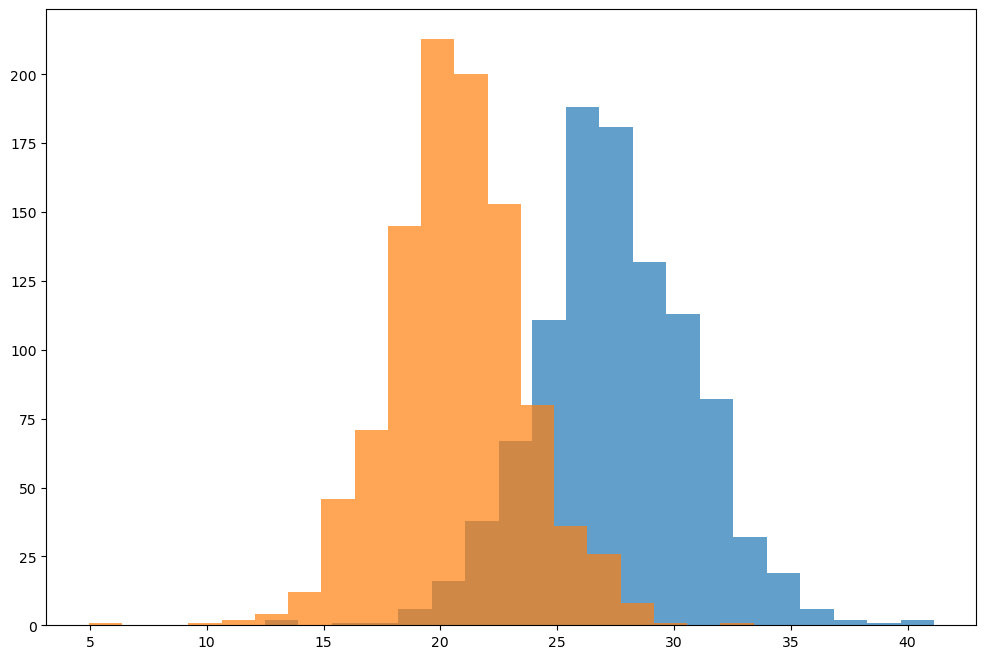

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(np.array(scm.intervention_samples), bins=20, alpha=.7)
ax.hist(np.array(scm.posterior_samples), bins=20, alpha=.7)

# Test network

In [2]:
graph = nx.DiGraph()
graph.add_edge("EGF", "SOS")

all_nodes = ["SOS", "EGF"]
obs_nodes = ["SOS", "EGF"]
latent_nodes = []
attrs = {node: (True if node not in obs_nodes and 
                node != "\\n" else False) for node in all_nodes}

nx.set_node_attributes(graph, attrs, name="hidden")

In [3]:
simplified_graph = simplify_latent_dag(graph, "hidden")
y0_graph = y0.graph.NxMixedGraph()
y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

In [4]:
n = 1000

EGF = np.random.normal(15, 4, n)
SOS = 5. + (2.*EGF) + np.random.normal(0, 1., n)

sim_data = pd.DataFrame(data=np.array([SOS,EGF]).T, 
                        columns=["SOS", "EGF"])

In [5]:
scm = SCM(sim_data, y0_graph)
scm.prepare_scm_input()
scm.fit_scm("SVI", num_steps=2500, initial_lr=.01, gamma=.01)

starting training
3838906899.305622
2874163.1727313194
22380.733880892072
8295.250773514543
9369.172553231907
6128.126815074451
5347.146247713429
5489.8089623792885
8039.930955844344
15430.373784930562
19674.429679428154
19747.125572330733
32359.832923758546
5974.654421943999
16194.53340575249
6294.142931689465
4919.723042263397
5694.861740190177
7194.476056146203
665761.0655298568
5156.591661292239
5616.443847916282
4532.000667569366
4578.623280398982
5546.547666823187


In [6]:
scm.learned_params

{'EGF_mean_mean_param': tensor(14.4713),
 'EGF_mean_scale_param': tensor(0.5341),
 'EGF_scale_param': tensor(0.1718),
 'SOS_intercept_mean_param': tensor(5.8957),
 'SOS_intercept_scale_param': tensor(0.7221),
 'SOS_EGF_coef_mean_param': tensor(1.9428),
 'SOS_EGF_coef_scale_param': tensor(0.0549),
 'SOS_scale_param': tensor(0.4536)}

In [7]:
scm.intervention("EGF", 20.)

In [37]:
# Posterior samples
post_samples = [scm.model(None, scm.root_nodes, scm.descendent_nodes, [], scm.learned_params)["SOS"] for i in range(1000)]

intervened_model = pyro.do(scm.model, data={"EGF": torch.tensor(20.)})
int_samples = [intervened_model(None, scm.root_nodes, scm.descendent_nodes, [], scm.learned_params)["SOS"] for i in range(1000)]

(array([  1.,   0.,   0.,   0.,   1.,   3.,   0.,   5.,   7.,  22.,  48.,
        147., 549., 139.,  38.,  16.,  13.,   6.,   1.,   4.]),
 array([-55.1634407 , -49.56267929, -43.96191406, -38.36115265,
        -32.76039124, -27.15962982, -21.5588665 , -15.95810413,
        -10.35734177,  -4.7565794 ,   0.84418297,   6.44494534,
         12.0457077 ,  17.64646912,  23.24723244,  28.84799576,
         34.44875717,  40.04951859,  45.65028381,  51.25104523,
         56.85180664]),
 <BarContainer object of 20 artists>)

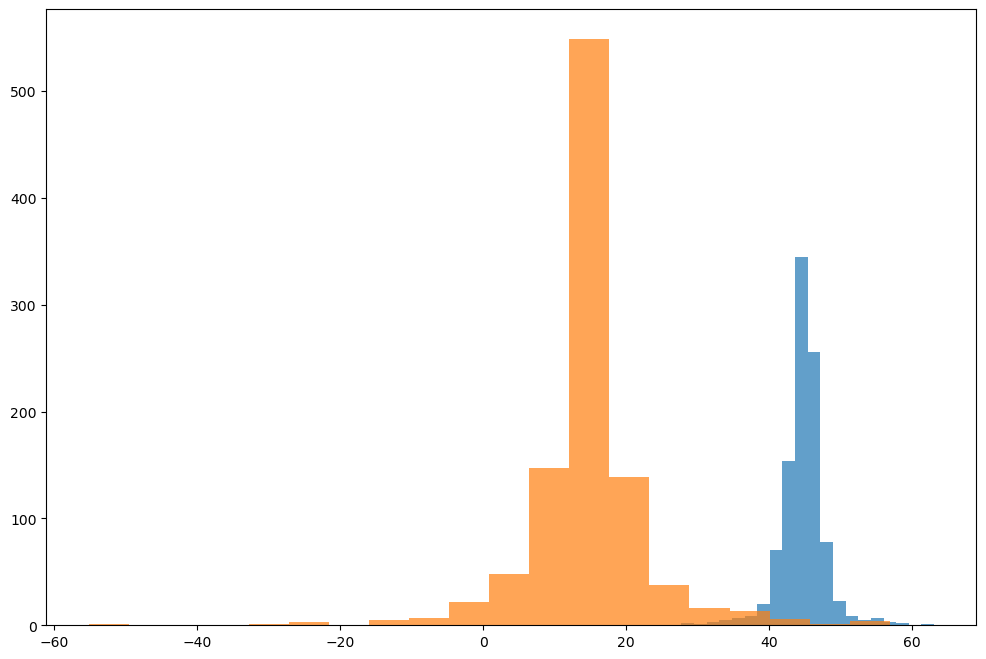

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(np.array(scm.intervention_samples), bins=20, alpha=.7)
ax.hist(np.array(scm.posterior_samples), bins=20, alpha=.7)

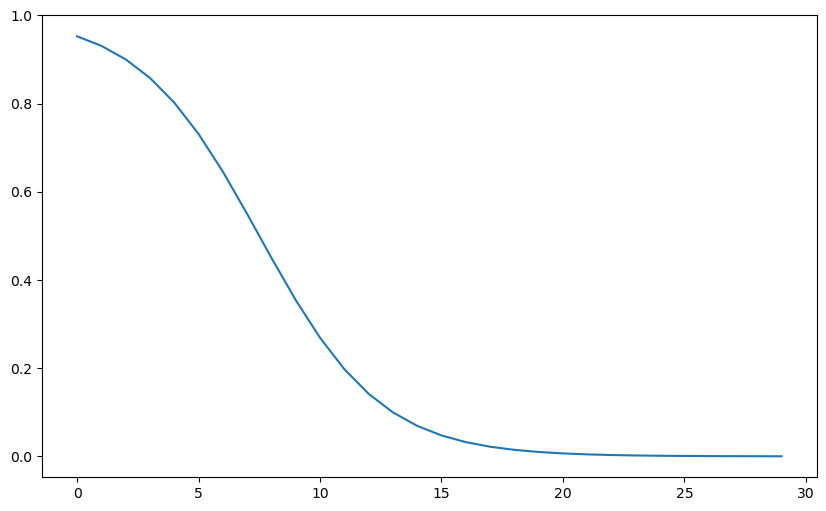

In [22]:
fig, ax = plt.subplots(figsize=(10,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.4 * i))) for i in range(0, 30)]
ax.plot(mnar_thresh)

In [17]:
pickle_filename = '../data/IGF_pathway/IGF_sim_data_10_reps.pkl'
with open(pickle_filename, 'rb') as pickle_file:
    sim_data = pickle.load(pickle_file)

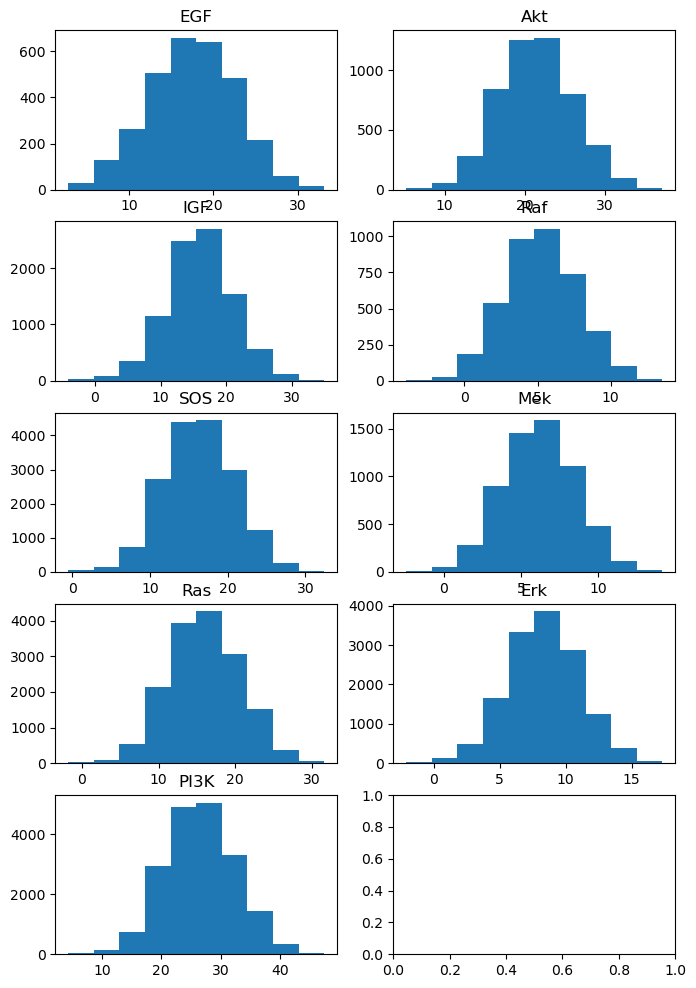

In [18]:
feat_data = sim_data["Feature_data"]
prot = feat_data["Protein"].unique()

fig, ax = plt.subplots(5, 2, figsize=(8,12))

for i in range(5):
    data0 = feat_data[feat_data["Protein"] == prot[i]]["Intensity"]
    ax[i, 0].hist(data0)
    ax[i, 0].set_title(prot[i])
    try:
        data1 = feat_data[feat_data["Protein"] == prot[i+5]]["Intensity"]
        ax[i, 1].hist(data1)
        ax[i, 1].set_title(prot[i+5])
    except:
        pass
    

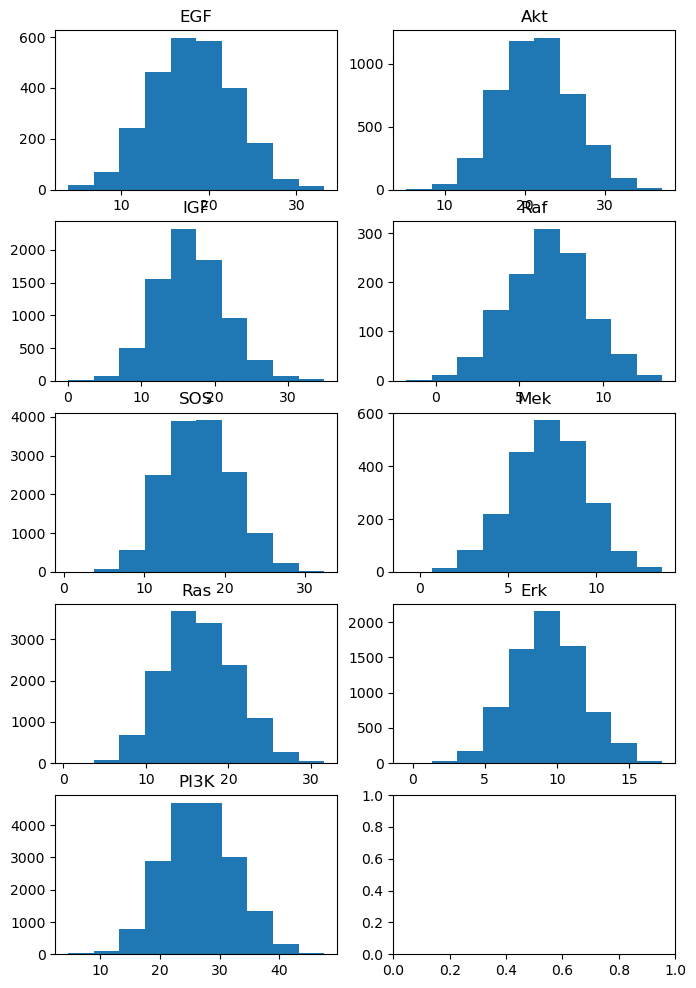

In [19]:
feat_data = sim_data["Feature_data"]
prot = feat_data["Protein"].unique()

fig, ax = plt.subplots(5, 2, figsize=(8,12))

for i in range(5):
    data0 = feat_data[feat_data["Protein"] == prot[i]]["Obs_Intensity"]
    ax[i, 0].hist(data0)
    ax[i, 0].set_title(prot[i])
    try:
        data1 = feat_data[feat_data["Protein"] == prot[i+5]]["Obs_Intensity"]
        ax[i, 1].hist(data1)
        ax[i, 1].set_title(prot[i+5])
    except:
        pass
    

In [128]:
feat_data.to_csv("../data/IGF_pathway/feature_data.csv", index=False)

In [4]:
sim_data = pd.read_csv("../data/IGF_pathway/protein_data.csv")
sim_data = sim_data.drop(columns="originalRUN")

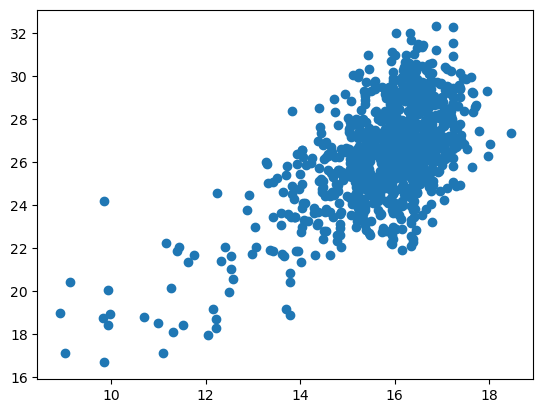

In [11]:
fig,ax = plt.subplots()

ax.scatter(sim_data["Ras"], sim_data["PI3K"])

In [5]:
scm = SCM(sim_data, y0_graph)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=1000, num_chains=4)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
scm.summary_stats

{'Akt_PI3K_coef': OrderedDict([('mean', 0.4262519),
              ('std', 0.015201198),
              ('median', 0.4263871),
              ('5.0%', 0.40019855),
              ('95.0%', 0.45007816),
              ('n_eff', 2952.2454984553756),
              ('r_hat', 1.0002122270481708)]),
 'Akt_intercept': OrderedDict([('mean', 9.497035),
              ('std', 0.40248492),
              ('median', 9.4961605),
              ('5.0%', 8.852624),
              ('95.0%', 10.163616),
              ('n_eff', 2948.641133068556),
              ('r_hat', 1.0002488407370018)]),
 'Akt_scale': OrderedDict([('mean', 1.123058),
              ('std', 0.025340965),
              ('median', 1.1224964),
              ('5.0%', 1.0815831),
              ('95.0%', 1.1640183),
              ('n_eff', 8141.461317040592),
              ('r_hat', 0.9997417959691131)]),
 'Erk_Mek_coef': OrderedDict([('mean', 0.9949812),
              ('std', 0.013682535),
              ('median', 0.99489135),
              ('5.0

In [12]:
scm.learned_params

{'Akt_PI3K_coef_mean_param': Array(0.4262519, dtype=float32),
 'Akt_PI3K_coef_scale_param': Array(0.0151993, dtype=float32),
 'Akt_intercept_mean_param': Array(9.497036, dtype=float32),
 'Akt_intercept_scale_param': Array(0.40243462, dtype=float32),
 'Akt_scale_param': Array(1.1230582, dtype=float32),
 'Erk_Mek_coef_mean_param': Array(0.9949813, dtype=float32),
 'Erk_Mek_coef_scale_param': Array(0.01368082, dtype=float32),
 'Erk_intercept_mean_param': Array(2.1536965, dtype=float32),
 'Erk_intercept_scale_param': Array(0.09390368, dtype=float32),
 'Erk_scale_param': Array(1.0391563, dtype=float32),
 'Mek_Raf_coef_mean_param': Array(1.1010401, dtype=float32),
 'Mek_Raf_coef_scale_param': Array(0.02437793, dtype=float32),
 'Mek_intercept_mean_param': Array(0.30297956, dtype=float32),
 'Mek_intercept_scale_param': Array(0.14352387, dtype=float32),
 'Mek_scale_param': Array(1.2503028, dtype=float32),
 'PI3K_Ras_coef_mean_param': Array(1.2041326, dtype=float32),
 'PI3K_Ras_coef_scale_param'

In [42]:
import numpyro
# Posterior samples
# post_samples = [scm.model(None, scm.root_nodes, scm.descendent_nodes,
#                            [], scm.learned_params)["Erk"] for _ in range(1000)]
int_samples = list()
int_samples2 = list()

for i in range(20):
    print(i)
    intervened_model = numpyro.handlers.do(scm.model, data={"SOS": i, "Ras": 5})
    int_samples.append([intervened_model(None, scm.root_nodes, scm.descendent_nodes,
                                    [], scm.learned_params)["Erk"] for _ in range(1000)])

    intervened_model = numpyro.handlers.do(scm.model, data={"SOS": i, "Ras": 10})
    int_samples2.append([intervened_model(None, scm.root_nodes, scm.descendent_nodes,
                                    [], scm.learned_params)["Erk"] for _ in range(1000)])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [45]:
np.mean(np.array(int_samples).flatten())

12.306787

In [46]:
np.mean(np.array(int_samples2).flatten())

11.075876

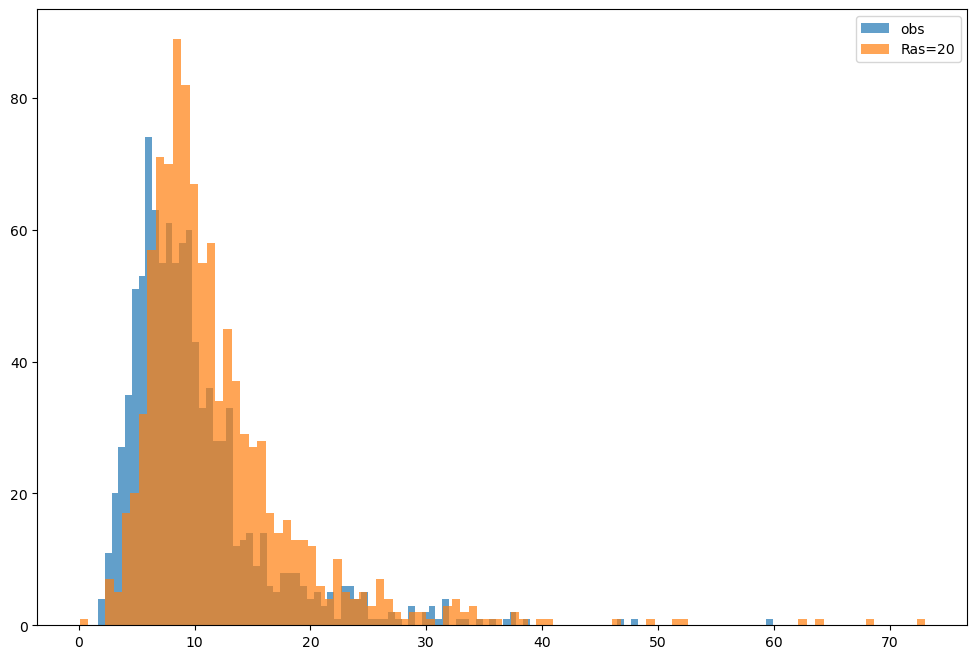

In [30]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(np.array(post_samples), bins=100, alpha=.7, label="obs")
ax.hist(np.array(int_samples), bins=100, alpha=.7, label="Ras=20")
ax.legend()

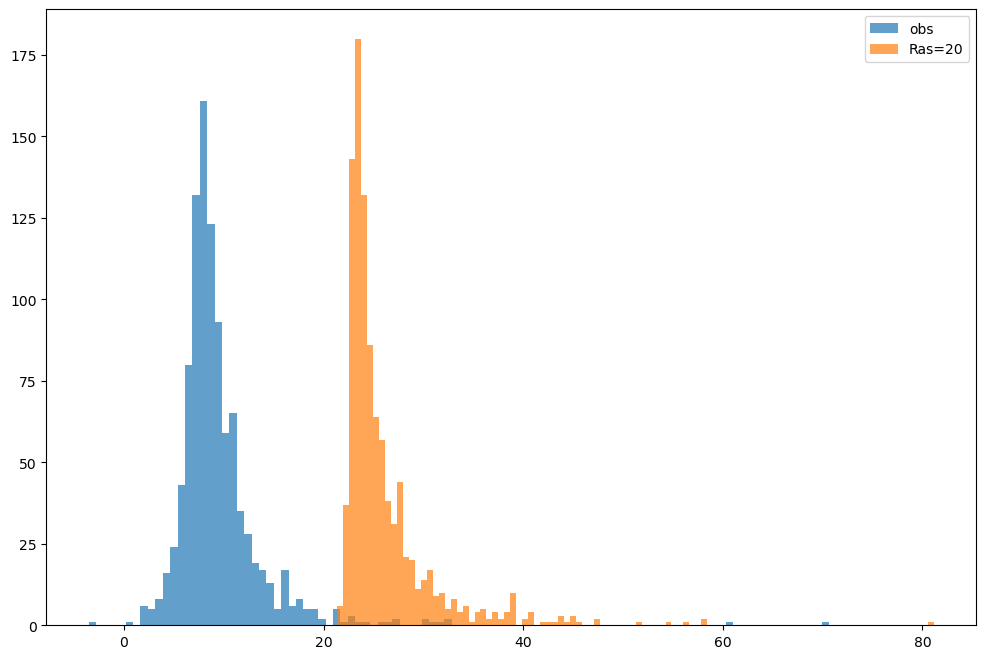

In [6]:
scm.intervention("Raf", "Erk", 20.)

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(np.array([i["Erk"] for i in scm.posterior_samples]), bins=100, alpha=.7, label="obs")
ax.hist(np.array(scm.intervention_samples), bins=100, alpha=.7, label="Ras=20")
ax.legend()

In [9]:
coef = {'EGF': {'intercept': 18.},
         'SOS': {'EGF': 0.6,
          'IGF': 0.6,
          'intercept': -4},
         'PI3K': {'EGF': .5,
          'IGF': 0.5,
          'Ras': .5,
          'intercept': 1.6},
         'IGF': {'intercept': 16.},
         'Ras': {'SOS': 1., 'intercept': -0.5},
         'Raf': {'Ras': 0.8,
          'Akt': -.4,
          'intercept': 1.75},
         'Akt': {'PI3K': 0.75, 'intercept': 2.},
         'Mek': {'Raf': 0.75, 'intercept': 2.},
         'Erk': {'Mek': 1.2, 'intercept': 1.}}
    
def calc_true_ace(coef):
    n = 1000

    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_obs = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = 20.
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_int = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    return [Erk_obs, Erk_int]

true = calc_true_ace(coef)

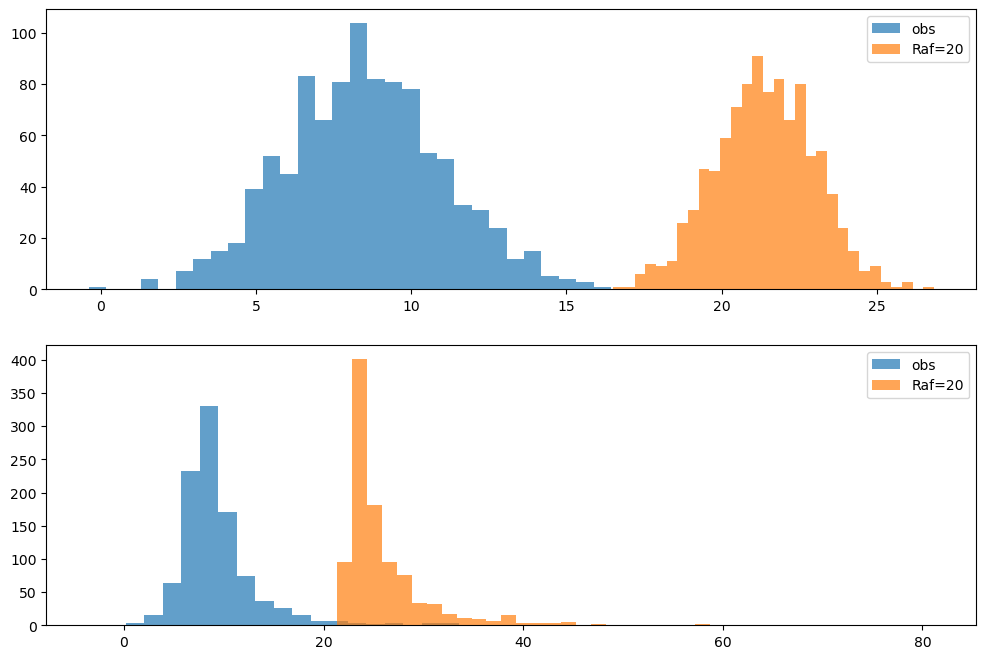

In [12]:
fig, ax = plt.subplots(2,1,figsize=(12,8))

ax[0].hist(np.array(true[0]), bins=30, alpha=.7, label="obs")
ax[0].hist(np.array(true[1]), bins=30, alpha=.7, label="Raf=20")
ax[0].legend()

ax[1].hist(np.array([i["Erk"] for i in scm.posterior_samples]), bins=40, alpha=.7, label="obs")
ax[1].hist(np.array(scm.intervention_samples), bins=40, alpha=.7, label="Raf=20")
ax[1].legend()

In [19]:
def calc_true_ace(coef):
    n = 1000

    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 5
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_obs = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 10
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_int = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    return [Erk_obs, Erk_int]
vals=calc_true_ace(coef)

In [20]:
np.mean(vals[0])

2.145290795469033

In [21]:
np.mean(vals[1])

5.072833316027138